# Catchment Areas (Baguio)

The following is a simple proof of concept code to calculate catchment areas using the Friction Surface. The 3 priority sites will be: Province of Bohol; Baguio City; and Maguidanao (BARMM)

In [1]:
import os, sys
import geopandas as gpd
import pandas as pd
import rasterio as rio
import numpy as np
from shapely.geometry import Point
import skimage.graph as graph

In [2]:
sys.path.append('/home/wb514197/Repos/gostrocks/src') # gostrocks is used for some basic raster operations (clip and standardize)
sys.path.append('/home/wb514197/Repos/GOSTNets_Raster/src') # gostnets_raster has functions to work with friction surface
sys.path.append('/home/wb514197/Repos/GOSTnets') # it also depends on gostnets for some reason
sys.path.append('/home/wb514197/Repos/INFRA_SAP') # only used to save some raster results

In [3]:
import GOSTRocks.rasterMisc as rMisc
import GOSTNetsRaster.market_access as ma
from infrasap import aggregator

no xarray


In [4]:
input_dir = "/home/wb514197/data/PHL/Data" # Copy of Gabriel's Data folder in SharePoint
repo_dir = os.path.dirname(os.path.realpath("."))
out_folder = "/home/wb514197/data/PHL/output"
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

### Administative Boundaries

In [5]:
iso3 = 'PHL'
global_admin = '/home/public/Data/GLOBAL/ADMIN/g2015_0_simplified.shp'
adm0 = gpd.read_file(global_admin)
adm0 = adm0.loc[adm0.ISO3166_1_==iso3]

In [6]:
global_admin2 = '/home/public/Data/GLOBAL/ADMIN/Admin2_Polys.shp'
adm2 = gpd.read_file(global_admin2)
adm2 = adm2.loc[adm2.ISO3==iso3].copy()
adm2 = adm2.to_crs("EPSG:4326")

In [7]:
adm2.WB_ADM1_NA.unique()

array(['Cordillera Administrative region (CAR)',
       'National Capital region (NCR)', 'Region I (Ilocos region)',
       'Region II (Cagayan Valley)', 'Region V (Bicol region)',
       'Region VI (Western Visayas)', 'Region VII (Central Visayas)',
       'Region VIII (Eastern Visayas)', 'Region XIII (Caraga)',
       'Autonomous region in Muslim Mindanao (ARMM)',
       'Region IX (Zamboanga Peninsula)', 'Region X (Northern Mindanao)',
       'Region XI (Davao Region)', 'Region XII (Soccsksargen)',
       'Region III (Central Luzon)', 'Region IV-A (Calabarzon)',
       'Region IV (Southern Tagalog)'], dtype=object)

In [8]:
# adm2 = adm2.loc[adm2.WB_ADM1_NA=='Region VII (Central Visayas)'].copy()

In [8]:
admin_name = "Baguio" #Bohol Benguet Maguindanao

In [9]:
adm3 = gpd.read_file(os.path.join(input_dir, "hdx", "phl_admbnda_adm3_psa_namria_20200529.shp"))

In [10]:
aoi = adm3.loc[adm3.ADM3_EN=='Baguio City'].copy()

In [11]:
# aoi = adm2.loc[adm2.WB_ADM2_NA==admin_name].copy()

<AxesSubplot:>

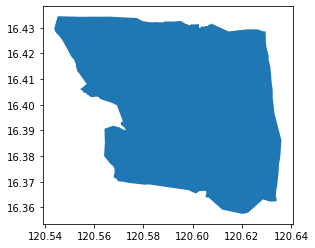

In [12]:
aoi.plot()

### Health Facilities

In [13]:
doh = gpd.read_file(os.path.join(input_dir, "doh_healthfacilities_april2020.shp"))

<AxesSubplot:>

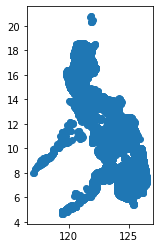

In [14]:
doh.plot()

In [15]:
# doh = doh.loc[doh.province=='Maguindanao'].copy() #BOHOL Maguindanao
doh = doh.loc[doh.municipali=='BAGUIO CITY (CAPITAL)'].copy()

In [16]:
doh.head()

,id,facilityco,healthfaci,typeofheal,barangay,municipali,province,region,status,address,style,geometry
8816,8912.0,DOH000000000003493,Fort Del Pilar Hospital,Hospital,Fort Del Pilar,BAGUIO CITY (CAPITAL),BENGUET,CAR (CORDILLERA ADMINISTRATIVE REGION,Functional,Kias Road,Hospital,POINT (120.61978 16.36512)
8817,8913.0,DOH000000000005693,Loakan Barangay Health Station,Barangay Health Station,Loakan Proper,BAGUIO CITY (CAPITAL),BENGUET,CAR (CORDILLERA ADMINISTRATIVE REGION,Functional,Loakan Proper,Barangay Health Station,POINT (120.61388 16.37662)
8818,8914.0,DOH000000000005693,Loakan Barangay Health Station ((New)),Barangay Health Station,Loakan Proper,BAGUIO CITY (CAPITAL),BENGUET,CAR (CORDILLERA ADMINISTRATIVE REGION,Functional,Loakan Proper,Barangay Health Station,POINT (120.61388 16.37662)
8819,8915.0,DOH000000000002759,Atok Trail Health Center,Rural Health Unit,Atok Trail,BAGUIO CITY (CAPITAL),BENGUET,CAR (CORDILLERA ADMINISTRATIVE REGION,Functional,Atok Trail Proper,Rural Health Unit,POINT (120.62648 16.37672)
8821,8917.0,DOH000000000003054,Scout Barrio Barangay Health Station,Barangay Health Station,Scout Barrio,BAGUIO CITY (CAPITAL),BENGUET,CAR (CORDILLERA ADMINISTRATIVE REGION,Functional,Scout Barrio Proper,Barangay Health Station,POINT (120.60838 16.39742)


Looking at the NHFR Excel tables received, it looks like there are three separate sheets per region (CV, Cebu, and CAR).
Load CV (Central Visaya) and try to match location data from DOH.

In [17]:
registry = pd.read_excel(os.path.join(input_dir, "NHFR_CAR.xlsx"))

In [18]:
registry.columns

Index(['Health Facility Code', 'Health Facility Code Short', 'Facility Name',
       'Old Health Facility Names', 'Old Health Facility Name 2',
       'Old Health Facility Name 3', 'Health Facility Type',
       'Ownership Major Classification',
       'Ownership Sub-Classification for Government facilities',
       'Ownership Sub-Classification for private facilities',
       'Street Name and #           ', 'Building name and #', 'Region Name',
       'Region PSGC', 'Province Name', 'Province PSGC',
       'City/Municipality Name', 'City/Municipality PSGC', 'Barangay Name',
       'Barangay PSGC', 'Zip Code', 'Landline Number', 'Landline Number 2',
       'Fax Number', 'Email Address', 'Alternate Email Address',
       'Official Website', 'Facility Head: Last Name',
       'Facility Head: First Name', 'Facility Head: Middle Name',
       'Facility Head: Position', 'Hospital Licensing Status',
       'Service Capability', 'Bed Capacity'],
      dtype='object')

In [19]:
registry["Province Name"].value_counts()

BENGUET              226
IFUGAO               215
ABRA                 203
KALINGA              162
APAYAO               153
MOUNTAIN PROVINCE    150
Name: Province Name, dtype: int64

In [20]:
registry = registry.loc[registry["Province Name"]=="BENGUET"].copy()

In [21]:
registry["Health Facility Type"].value_counts()

Barangay Health Station                            167
Rural Health Unit                                   30
Hospital                                            14
Infirmary                                            7
Birthing Home                                        3
COVID-19 Testing Laboratory                          3
Animal Bite Treatment Center                         1
Drug Abuse Treatment and Rehabilitation Centers      1
Name: Health Facility Type, dtype: int64

In [22]:
len(registry), len(doh)

(226, 23)

In [23]:
registry = registry.merge(doh, left_on='Health Facility Code', right_on='facilityco', how='left')

In [24]:
registry.geometry.isna().value_counts()

True     205
False     22
Name: geometry, dtype: int64

In [25]:
registry = gpd.GeoDataFrame(registry, geometry='geometry', crs=doh.crs)

<AxesSubplot:>

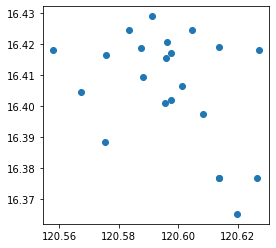

In [26]:
registry.plot()

Strategies to match location for missing facilities: look for zip codes, barangay (adm4 file), maybe geocode (not very confident on this last option)  
For now work with those that have location

In [27]:
registry = registry.loc[~registry.geometry.isna()].copy()

In [30]:
# registry = doh.copy()

In [28]:
registry.reset_index(drop=True, inplace=True)

In [64]:
# registry = registry.loc[registry.intersects(aoi.unary_union)].copy()

In [31]:
# registry["Health Facility Type"].unique()
registry.typeofheal.unique()

array(['Hospital', 'Rural Health Unit', 'Barangay Health Station'],
      dtype=object)

Something important to ask is whether we should be working with health stations. There are hundreds more, so it might be more insightful to consider access to hospitals and primary care centers.

In [32]:
# registry_filter = registry.loc[registry["Health Facility Type"]!="Barangay Health Station"].copy()
registry_filter = registry.loc[registry["typeofheal"]!="Barangay Health Station"].copy()

### Friction Surface

In [33]:
global_friction_surface = "/home/public/Data/GLOBAL/INFRA/FRICTION_2020/2020_motorized_friction_surface.geotiff"
wp_1km = os.path.join(input_dir, "phl_ppp_2020_1km_Aggregated_UNadj.tif")

In [34]:
inG = rio.open(global_friction_surface)

In [35]:
# Clip the travel raster to AOI
out_travel_surface = os.path.join(out_folder, f"travel_surface_{admin_name}.tif")
rMisc.clipRaster(inG, aoi, out_travel_surface, bbox=False, buff=0.1)

/home/wb514197/Repos/gostrocks/src/GOSTRocks/rasterMisc.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  inD = inD.buffer(buff)


In [36]:
inP = rio.open(wp_1km)

In [37]:
# Clip the pop raster to AOI
out_pop = os.path.join(out_folder, f"pop_{admin_name}.tif")
rMisc.clipRaster(inP, aoi, out_pop, bbox=False, buff=0.1)

/home/wb514197/Repos/gostrocks/src/GOSTRocks/rasterMisc.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  inD = inD.buffer(buff)


In [38]:
travel_surf = rio.open(out_travel_surface)
pop_surf = rio.open(out_pop)

In [39]:
# standardize so that they have the same number of pixels and dimensions
out_pop_surface_std = os.path.join(out_folder, f"pop_{admin_name}_STD.tif")
rMisc.standardizeInputRasters(pop_surf, travel_surf, out_pop_surface_std, resampling_type="nearest")

[array([[[-99999., -99999., -99999., ..., -99999., -99999., -99999.],
         [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
         [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
         ...,
         [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
         [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
         [-99999., -99999., -99999., ..., -99999., -99999., -99999.]]],
       dtype=float32),
 {'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': -99999.0,
  'width': 36,
  'height': 35,
  'count': 1,
  'crs': CRS.from_epsg(4326),
  'transform': Affine(0.008333333333333333, 0.0, 120.44166666666666,
         0.0, -0.008333333333333333, 16.54166666666667)}]

In [40]:
# create a data frame of all points
pop_surf = rio.open(out_pop_surface_std)
pop = pop_surf.read(1, masked=True)
indices = list(np.ndindex(pop.shape))
xys = [Point(pop_surf.xy(ind[0], ind[1])) for ind in indices]
res_df = pd.DataFrame({
    'spatial_index': indices, 
    'xy': xys, 
    'pop': pop.flatten()
})
res_df['pointid'] = res_df.index

/home/wb514197/.conda/envs/graph/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:121: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [41]:
# create MCP object
inG_data = travel_surf.read(1) * 1000 # minutes to travel 1 meter, convert to km
# Correct no data values
inG_data[inG_data < 0] = 9999999999 # untraversable
# inG_data[inG_data < 0] = np.nan
mcp = graph.MCP_Geometric(inG_data)

## Catchment Area

For every health facility, calculate travel time between origin point and health facility.  
Then for each point, keep the id of the health facility with the minimum travel time (closest idx).

In [42]:
for idx, dest in registry.iterrows():
    dest_gdf = gpd.GeoDataFrame([dest], geometry='geometry', crs='EPSG:4326')
    res = ma.calculate_travel_time(travel_surf, mcp, dest_gdf)[0]
    res_df.loc[:,idx] = res.flatten()

In [43]:
# drop non-populated points
res_df = res_df.loc[res_df['pop']>0].copy()
res_df = res_df.loc[~(res_df['pop'].isna())].copy()

In [44]:
# res_df.loc[:, registry.index] = res_df.loc[:, registry.index].apply(lambda x: x/60) # convert to hours

In [45]:
res_df.head()

,spatial_index,xy,pop,pointid,0,1,2,3,4,5,...,12,13,14,15,16,17,18,19,20,21
45,"(1, 9)",POINT (120.52083333333333 16.529166666666672),72.735962,45,52.235852,52.650066,56.892707,51.003619,50.650066,54.064280,...,51.235852,51.771386,56.064280,56.064280,50.235852,50.235852,51.268338,53.682552,51.854124,50.003619
46,"(1, 10)",POINT (120.52916666666665 16.529166666666672),110.319359,46,66.558603,66.972816,71.215457,65.326370,64.972816,68.387030,...,65.558603,66.094136,70.387030,70.387030,64.558603,64.558603,65.591088,68.005302,66.176875,64.326370
47,"(1, 11)",POINT (120.5375 16.529166666666672),28.916502,47,63.253009,63.667223,67.909863,62.020776,61.667223,65.081436,...,62.253009,62.788543,67.081436,67.081436,61.253009,61.253009,62.285495,64.699708,62.871281,61.020776
48,"(1, 12)",POINT (120.54583333333332 16.529166666666672),43.524239,48,66.272967,66.687181,70.929821,65.040734,64.687181,68.101394,...,65.272967,65.808501,70.101394,70.101394,64.272967,64.272967,65.305453,67.719666,65.891239,64.040734
49,"(1, 13)",POINT (120.55416666666666 16.529166666666672),55.734379,49,42.746700,43.160913,47.403554,41.514467,41.160913,44.575127,...,41.746700,42.282234,46.575127,46.575127,40.746700,40.746700,42.400506,44.814719,42.575127,40.514467


In [46]:
res_df.loc[:, "closest_idx"] = res_df[registry.index].idxmin(axis=1) # id of health facility that yields the minimum travel time
res_df.loc[:, "closest_idx_filter"] = res_df[registry_filter.index].idxmin(axis=1) # same but without health stations

In [47]:
res_df.loc[:,'xy'] = res_df['xy'].apply(Point)

In [48]:
res_gdf = gpd.GeoDataFrame(res_df, geometry='xy', crs='EPSG:4326')

In [49]:
#libraries for plotting maps
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from rasterio.plot import plotting_extent
import contextily as ctx
import random

### Save some maps
Issue here is that the colors are being repeated and grouped

In [50]:
graphs_dir = os.path.join(repo_dir, 'output')
if not os.path.exists(graphs_dir):
    os.mkdir(graphs_dir)

In [51]:
# spec = plt.cm.get_cmap('tab20c')
number_of_colors = len(res_gdf.closest_idx.unique())

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

custom = colors.ListedColormap(color)

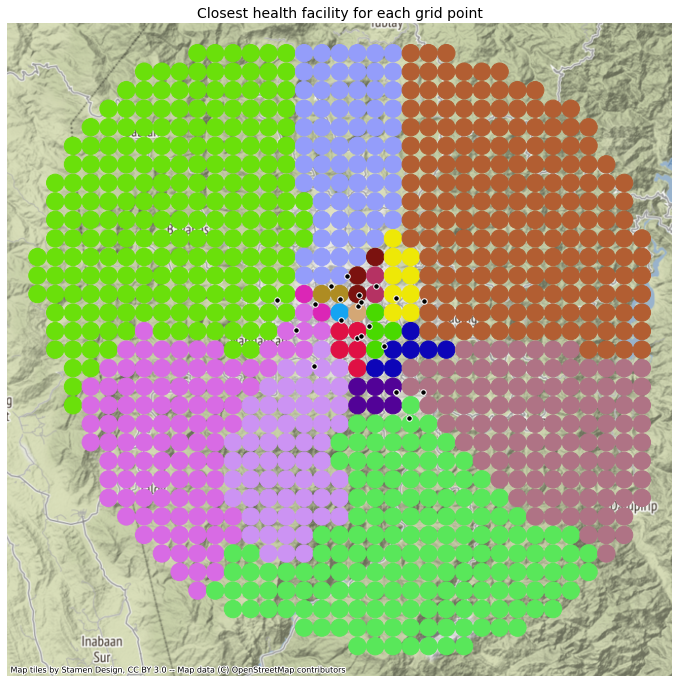

In [59]:
figsize = (12,12)
fig, ax = plt.subplots(1, 1,  figsize = figsize)
ax.set_title("Closest health facility for each grid point", fontsize=14)
res_gdf.plot('closest_idx', ax = ax, categorical=True, legend=False, cmap=custom, markersize=300)
plt.axis('off')
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)
registry.plot(ax=ax, facecolor='black', edgecolor='white', markersize=30, alpha=1)
plt.savefig(os.path.join(graphs_dir, f"{admin_name}_Catchment_AllHealth.png"), dpi=300, bbox_inches='tight', facecolor='white')

In [60]:
# spec = plt.cm.get_cmap('tab20c')
number_of_colors = len(res_gdf.closest_idx_filter.unique())

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

custom = colors.ListedColormap(color)

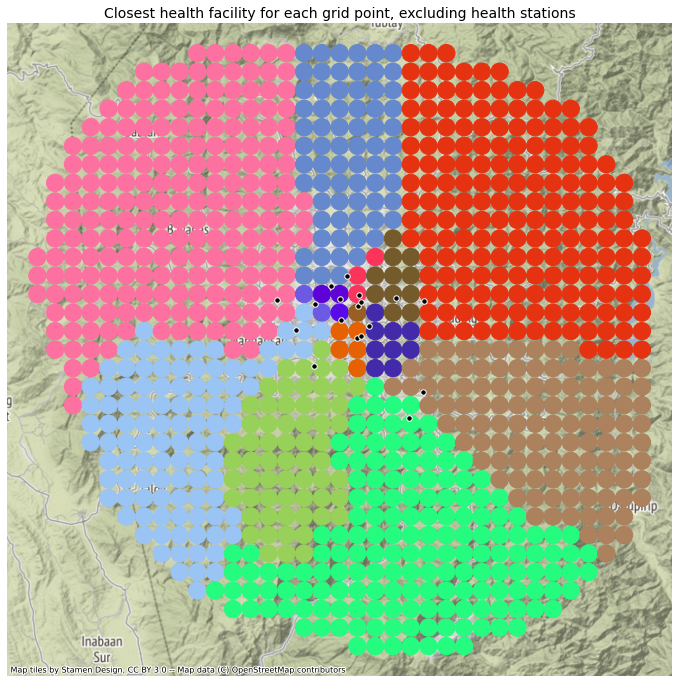

In [61]:
figsize = (12,12)
fig, ax = plt.subplots(1, 1,  figsize = figsize)
ax.set_title("Closest health facility for each grid point, excluding health stations", fontsize=14)
res_gdf.plot('closest_idx_filter', ax = ax, categorical=True, legend=False, cmap=custom, markersize=300)
plt.axis('off')
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)
registry_filter.plot(ax=ax, facecolor='black', edgecolor='white', markersize=30, alpha=1)
plt.savefig(os.path.join(graphs_dir, f"{admin_name}_Catchment_NoStations.png"), dpi=300, bbox_inches='tight', facecolor='white')

### Calculate travel time to nearest health facility (excluding stations)

In [47]:
pop_surf = rio.open(out_pop_surface_std)
pop = pop_surf.read(1, masked=True)
indices = list(np.ndindex(pop.shape))
xys = [Point(pop_surf.xy(ind[0], ind[1])) for ind in indices]
res_df = pd.DataFrame({
    'spatial_index': indices, 
    'xy': xys, 
    'pop': pop.flatten()
})
res_df['pointid'] = res_df.index

In [48]:
# same analysis but we feed all destinations at once, this returns the travel time to closest
res_min = ma.calculate_travel_time(travel_surf, mcp, registry_filter)[0]

In [49]:
res_df.loc[:, f"tt_health"] = res_min.flatten()

In [50]:
res_df = res_df.loc[res_df['pop']>0].copy()
res_df = res_df.loc[~(res_df['pop'].isna())].copy()

In [51]:
res_df.head()

,spatial_index,xy,pop,pointid,tt_health
1583,"(11, 120)",POINT (124.6208333333333 10.2625),233.189651,1583,54.864499
1676,"(12, 80)",POINT (124.2875 10.25416666666667),94.150398,1676,35.676160
1677,"(12, 81)",POINT (124.2958333333333 10.25416666666667),362.527374,1677,34.981278
1682,"(12, 86)",POINT (124.3375 10.25416666666667),24.213766,1682,36.106657
1695,"(12, 99)",POINT (124.4458333333333 10.25416666666667),176.003372,1695,39.898555


In [53]:
res_df.tt_health.describe()

count    5194.000000
mean       11.641249
std        11.376083
min         0.000000
25%         4.767767
50%         8.293451
75%        13.958109
max       120.100080
Name: tt_health, dtype: float64

These values seem really low! (minutes)  
Maybe becuase it's an island? We need to do some checks...

In [54]:
res_df.loc[:,'xy'] = res_df['xy'].apply(Point)
res_gdf_tt = gpd.GeoDataFrame(res_df, geometry='xy', crs='EPSG:4326')

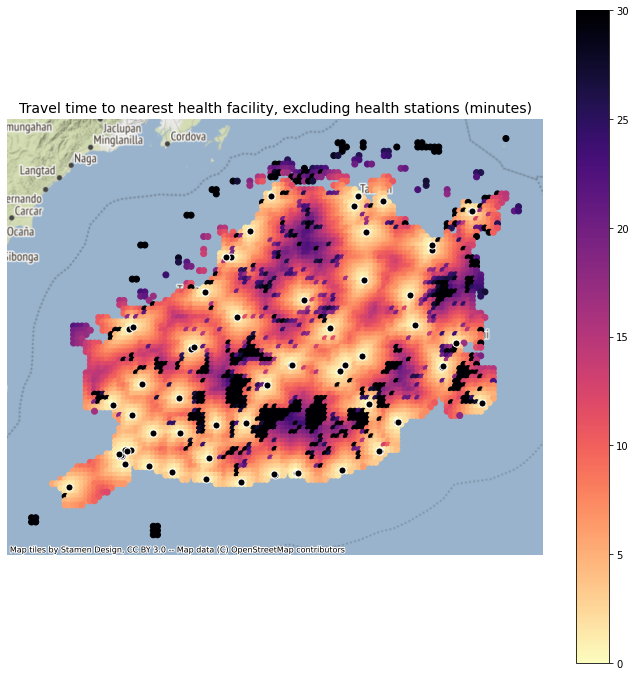

In [60]:
figsize = (12,12)
fig, ax = plt.subplots(1, 1,  figsize = figsize)
ax.set_title("Travel time to nearest health facility, excluding health stations (minutes)", fontsize=14)
res_gdf_tt.plot('tt_health', ax = ax, categorical=False, legend=True, vmin=0, vmax=30, cmap='magma_r')
plt.axis('off')
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)
registry_filter.plot(ax=ax, facecolor='black', edgecolor='white', markersize=50, alpha=1)
plt.savefig(os.path.join(graphs_dir, "Bohol_TravelTime_NoStations.png"), dpi=300, bbox_inches='tight', facecolor='white')

In [129]:
# res_min[res_min>99999999] = np.nan
# res_min = res_min/60

In [130]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

In [155]:
# figsize = (12,12)
# fig, ax = plt.subplots(1, 1,  figsize = figsize)
# ax.set_title("Travel time to nearest health facility", fontsize=14)

# plt.axis('off')
# ext = plotting_extent(pop_surf)

# im = ax.imshow(res_min, vmin=0, vmax=1, cmap='magma_r', extent=ext)
# # im = ax.imshow(res_min, norm=colors.PowerNorm(gamma=0.05), cmap='YlOrRd', extent=ext)
# # im = ax.imshow(res_min, cmap=newcmp, extent=ext)

# # ctx.add_basemap(ax, source=ctx.providers.Esri.WorldShadedRelief, crs='EPSG:4326', zorder=-10)
# ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)

# registry_filter.plot(ax=ax, facecolor='black', edgecolor='white', markersize=50, alpha=1)
# aoi.plot(ax=ax, facecolor='none', edgecolor='black')

# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size="4%", pad=0.1)
# cb = fig.colorbar(im, cax=cax, orientation='vertical')

# plt.savefig(os.path.join(graphs_dir, "Bohol_TravelTime_NoStations.png"), dpi=300, bbox_inches='tight', facecolor='white')
# # fig = ax.get_figure()
# # fig.savefig(
# #     os.path.join(out_folder, "MNG_AirportTravelTime.png"),
# #     facecolor='white', edgecolor='none'
# # )

Save some output data to check values

In [77]:
registry.loc[:, "idx"] = registry.index

In [79]:
registry.to_file(os.path.join(out_folder, "registry.shp"))

/home/wb514197/.conda/envs/graph/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


In [83]:
raster_path = out_pop_surface_std

In [120]:
res_gdf.loc[:, "geometry"] = res_gdf.loc[:, "xy"]

In [121]:
res_gdf.loc[:, "closest_idx"] = res_gdf.loc[:, "closest_idx"].astype('int32')

In [102]:
aggregator.rasterize_gdf(res_gdf, 'closest_idx', raster_path, os.path.join(out_folder, "closest_idx_.tif"), nodata=-1)